Starting Epoch 1/100...
Epoch 1/100 completed!
Starting Epoch 2/100...
Epoch 2/100 completed!
Starting Epoch 3/100...
Epoch 3/100 completed!
Starting Epoch 4/100...
Epoch 4/100 completed!
Starting Epoch 5/100...
Epoch 5/100 completed!
Starting Epoch 6/100...
Epoch 6/100 completed!
Starting Epoch 7/100...
Epoch 7/100 completed!
Starting Epoch 8/100...
Epoch 8/100 completed!
Starting Epoch 9/100...
Epoch 9/100 completed!
Starting Epoch 10/100...
Epoch 10/100 completed!
Starting Epoch 11/100...
Epoch 11/100 completed!
Starting Epoch 12/100...
Epoch 12/100 completed!
Starting Epoch 13/100...
Epoch 13/100 completed!
Starting Epoch 14/100...
Epoch 14/100 completed!
Starting Epoch 15/100...
Epoch 15/100 completed!
Starting Epoch 16/100...
Epoch 16/100 completed!
Starting Epoch 17/100...
Epoch 17/100 completed!
Starting Epoch 18/100...
Epoch 18/100 completed!
Starting Epoch 19/100...
Epoch 19/100 completed!
Starting Epoch 20/100...
Epoch 20/100 completed!
Starting Epoch 21/100...
Epoch 21/100 

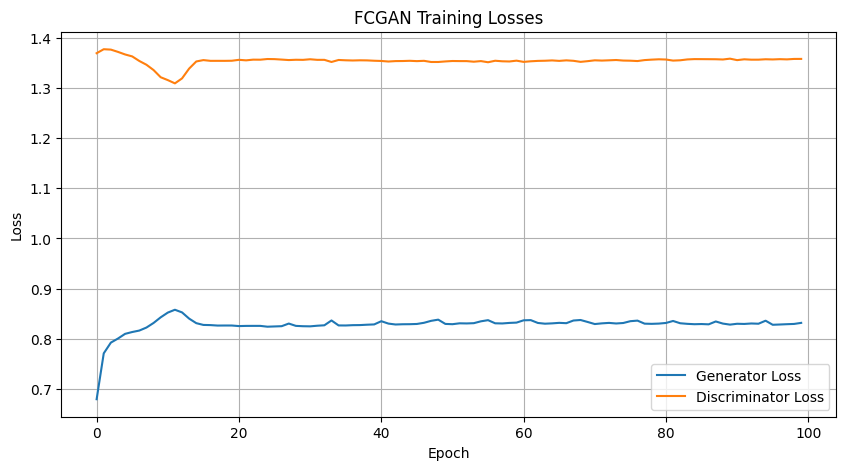

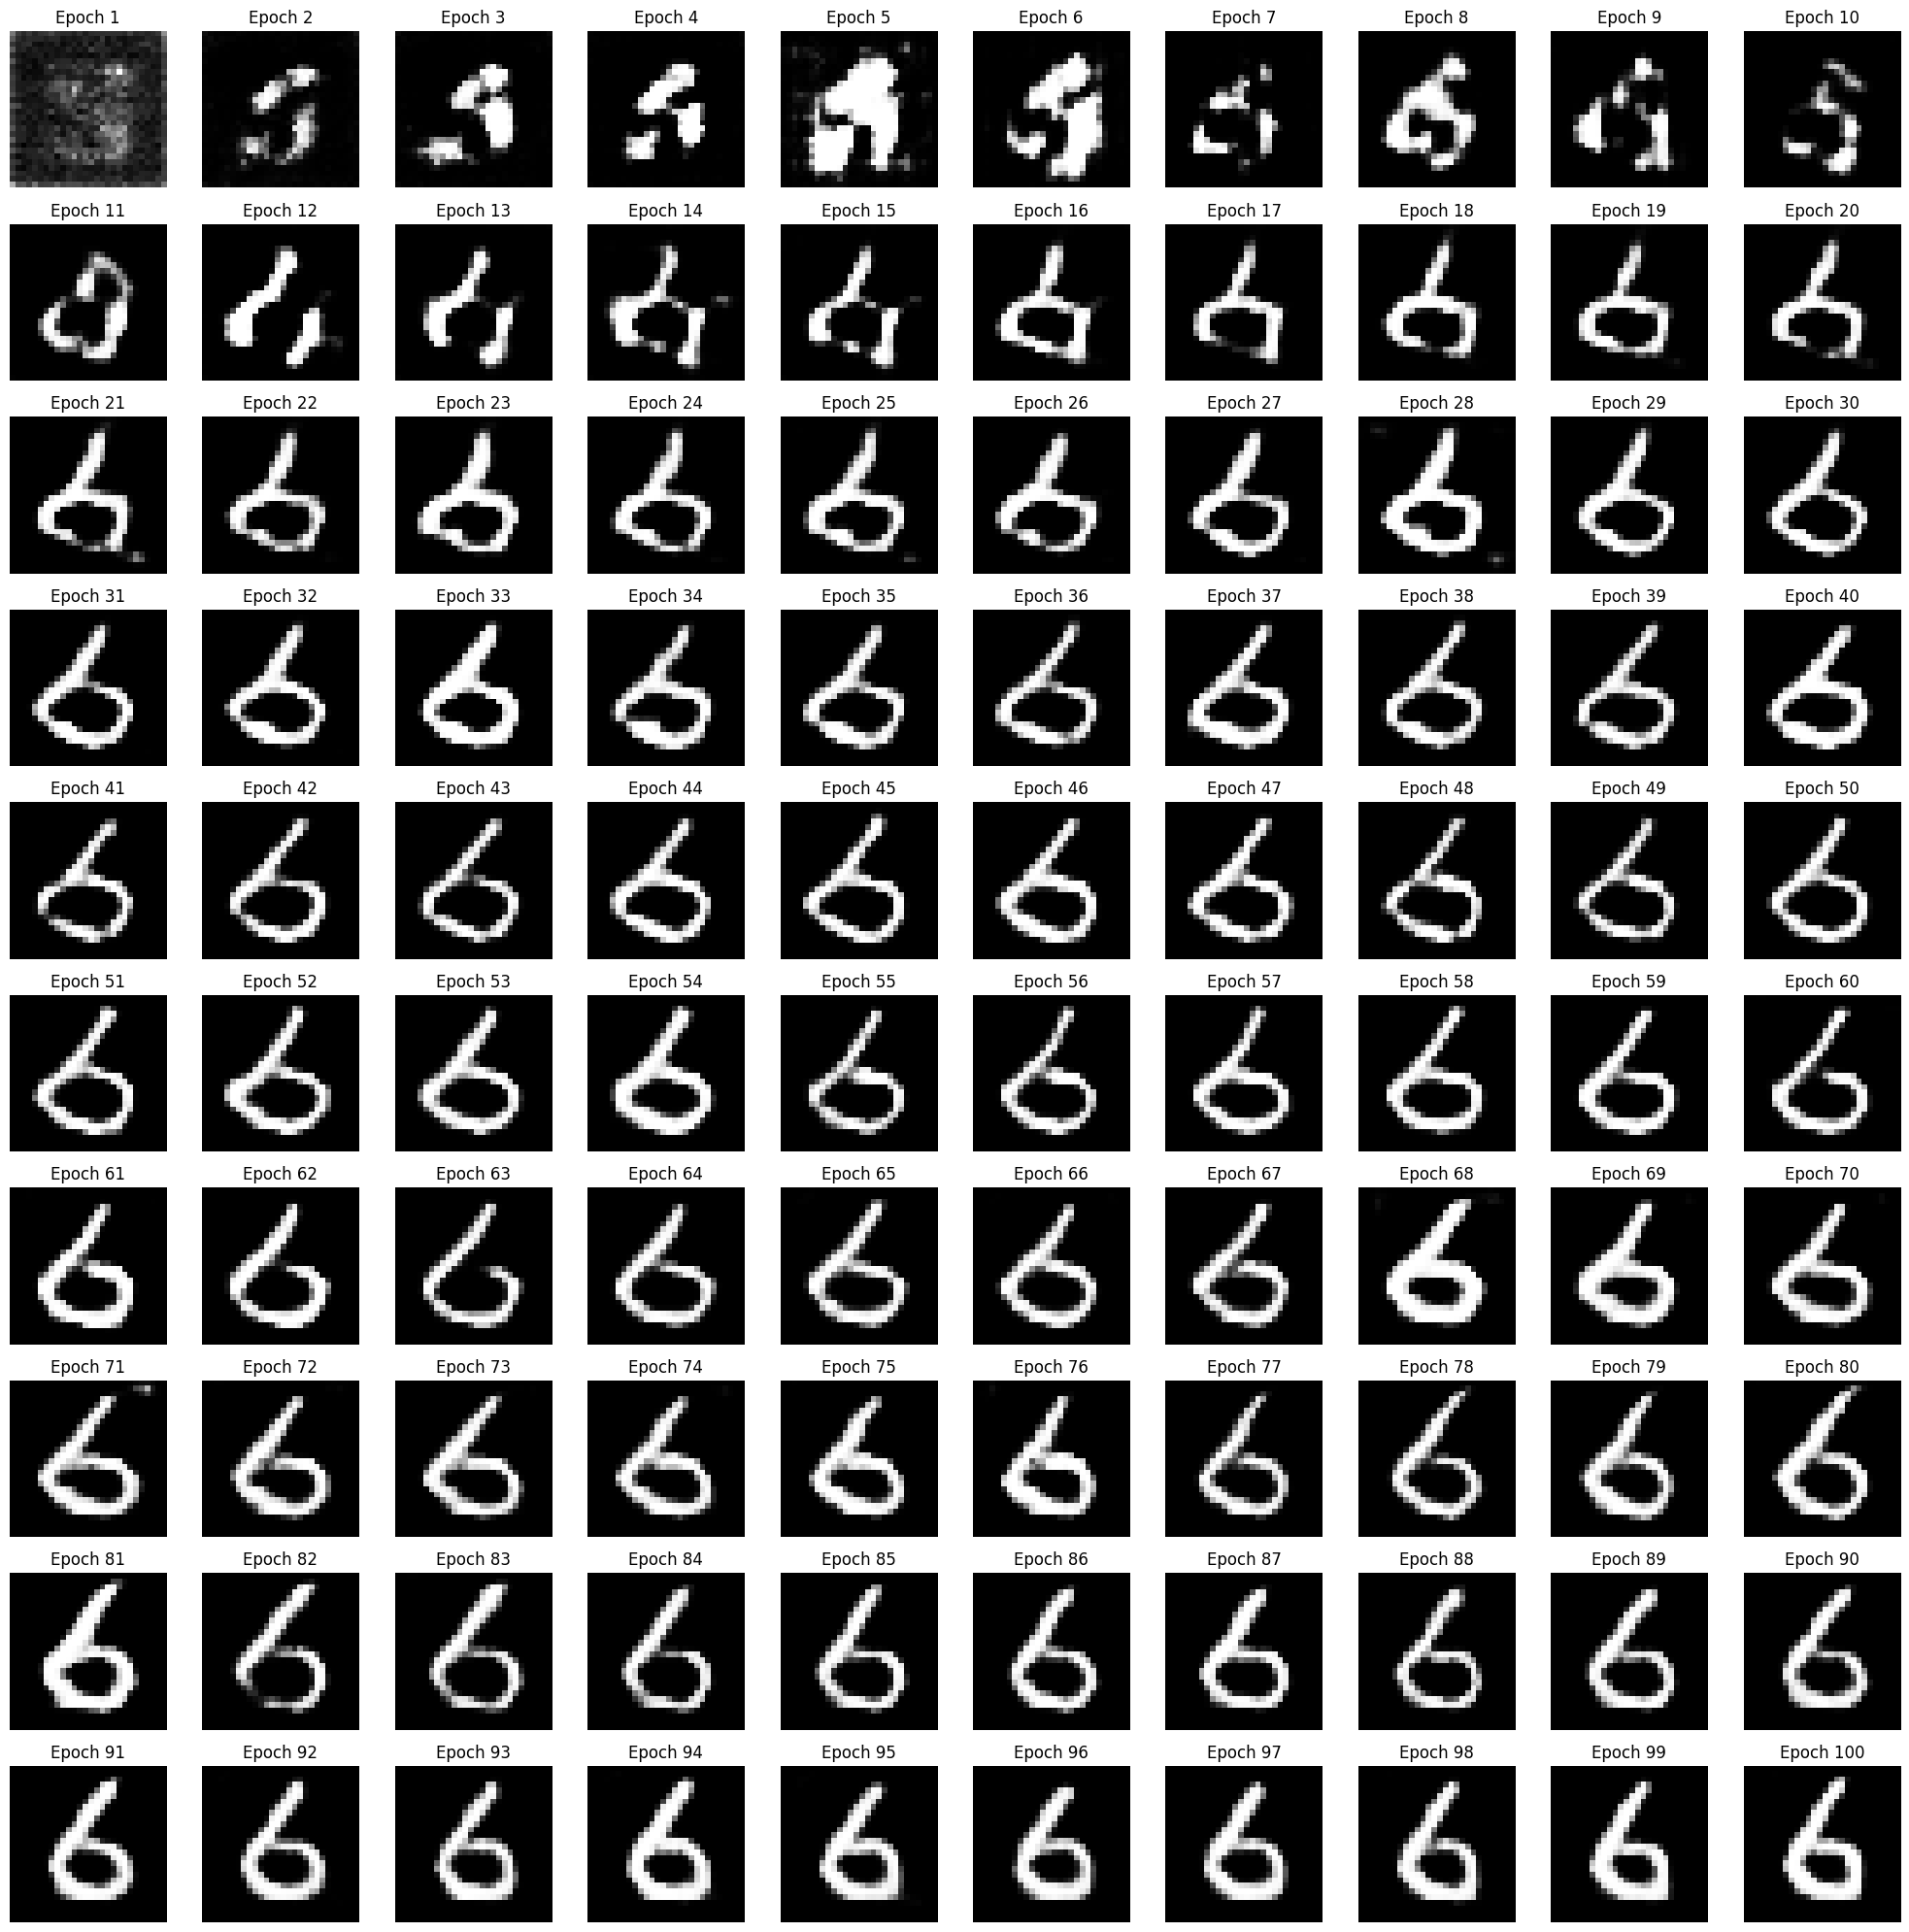

In [22]:
# ====== Imports ======
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# ====== Data Loading ======
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ====== Generator ======
def make_fcgan_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(1, 1, 100)),
        layers.Conv2DTranspose(256, 7, strides=1, padding='valid'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh')
    ])
    return model

# ====== Discriminator ======
def make_fcgan_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(1, 7, strides=1, padding='valid'),
        layers.Activation('sigmoid')
    ])
    return model

# ====== Loss ======
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    # Optional: apply label smoothing to real labels
    real_labels = tf.ones_like(real_output) * 0.9
    fake_labels = tf.zeros_like(fake_output)
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    return real_loss + fake_loss

@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE, 1, 1, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# ====== Training Loop ======
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, fixed_noise, image_list):
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(
                image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer
            )
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            num_batches += 1

        gen_losses.append(total_gen_loss / num_batches)
        disc_losses.append(total_disc_loss / num_batches)

        generated_images = generator(fixed_noise, training=False)
        image_list.append(generated_images)
        print(f"Epoch {epoch + 1}/{epochs} completed!")

    return gen_losses, disc_losses

# ====== Image Visualization ======
def visualize_images(image_list):
    epochs = len(image_list)
    cols = 10
    rows = (epochs + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(image_list)):
        axes[i].imshow((image_list[i][0, :, :, 0] + 1) / 2.0, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Epoch {i+1}")

    for i in range(len(image_list), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ====== Loss Plotting ======
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("FCGAN Training Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

# ====== Full Reset Before Training ======
fcgan_generator = make_fcgan_generator()
fcgan_discriminator = make_fcgan_discriminator()
fcgan_generator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
fcgan_discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)

fixed_noise = tf.random.normal([1, 1, 1, 100])  # Correct shape
fcgan_images = []

# ====== Run Training ======
gen_losses, disc_losses = train(
    train_dataset,
    epochs=100,
    generator=fcgan_generator,
    discriminator=fcgan_discriminator,
    generator_optimizer=fcgan_generator_optimizer,
    discriminator_optimizer=fcgan_discriminator_optimizer,
    fixed_noise=fixed_noise,
    image_list=fcgan_images
)

# ====== Visualize Results ======
plot_losses(gen_losses, disc_losses)
visualize_images(fcgan_images)


Training DCGAN...
Starting Epoch 1/100...
Epoch 1/100 completed!
Starting Epoch 2/100...
Epoch 2/100 completed!
Starting Epoch 3/100...
Epoch 3/100 completed!
Starting Epoch 4/100...
Epoch 4/100 completed!
Starting Epoch 5/100...
Epoch 5/100 completed!
Starting Epoch 6/100...
Epoch 6/100 completed!
Starting Epoch 7/100...
Epoch 7/100 completed!
Starting Epoch 8/100...
Epoch 8/100 completed!
Starting Epoch 9/100...
Epoch 9/100 completed!
Starting Epoch 10/100...
Epoch 10/100 completed!
Starting Epoch 11/100...
Epoch 11/100 completed!
Starting Epoch 12/100...
Epoch 12/100 completed!
Starting Epoch 13/100...
Epoch 13/100 completed!
Starting Epoch 14/100...
Epoch 14/100 completed!
Starting Epoch 15/100...
Epoch 15/100 completed!
Starting Epoch 16/100...
Epoch 16/100 completed!
Starting Epoch 17/100...
Epoch 17/100 completed!
Starting Epoch 18/100...
Epoch 18/100 completed!
Starting Epoch 19/100...
Epoch 19/100 completed!
Starting Epoch 20/100...
Epoch 20/100 completed!
Starting Epoch 21/10

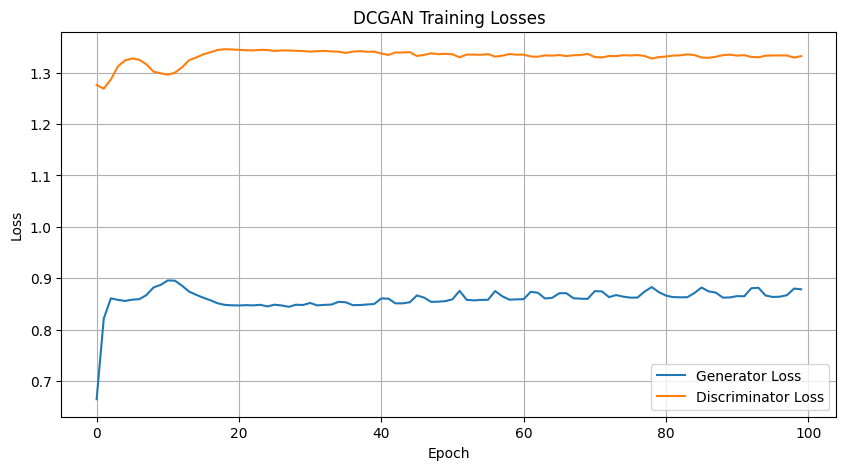

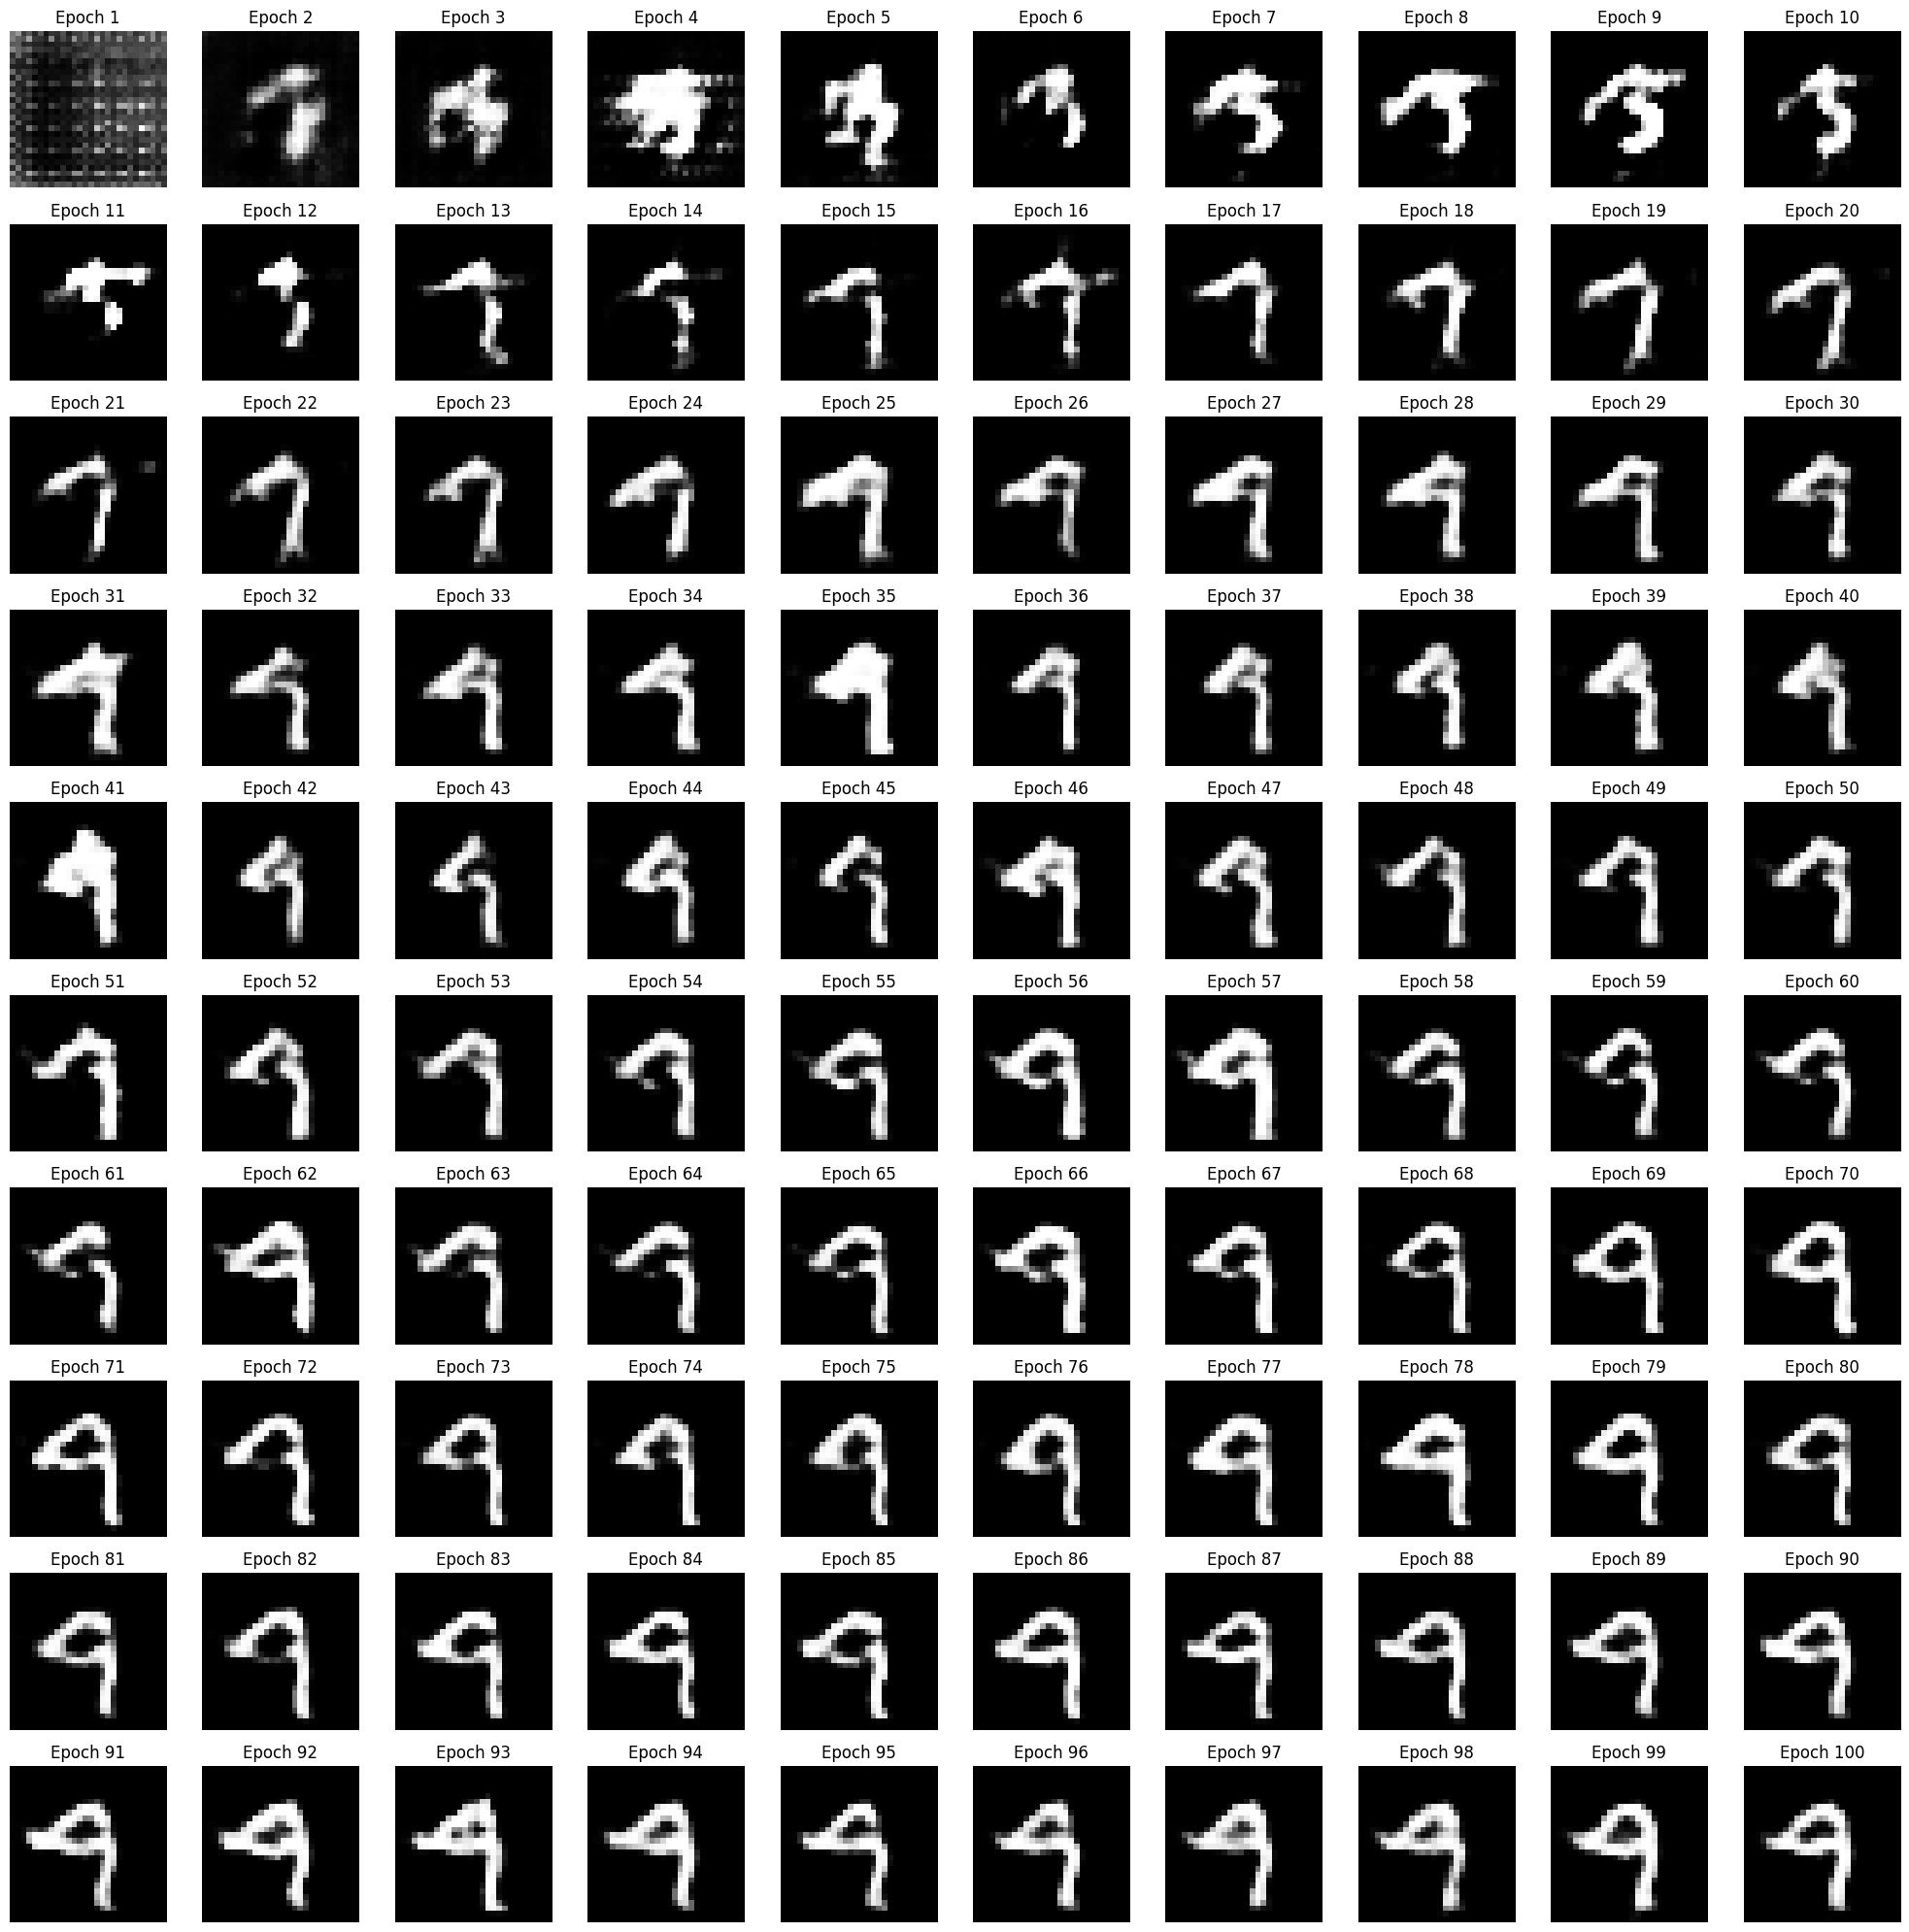

In [24]:
# Define DCGAN Generator
def make_dcgan_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define DCGAN Discriminator
def make_dcgan_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss with label smoothing for real labels
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output) * 0.9  # label smoothing
    fake_labels = tf.zeros_like(fake_output)
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    return real_loss + fake_loss

@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE,100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, fixed_noise, image_list):
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}...")
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(
                image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer
            )
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            num_batches += 1

        gen_losses.append(total_gen_loss / num_batches)
        disc_losses.append(total_disc_loss / num_batches)

        generated_images = generator(fixed_noise, training=False)
        image_list.append(generated_images)
        print(f"Epoch {epoch + 1}/{epochs} completed!")

    return gen_losses, disc_losses

def visualize_images(image_list):
    epochs = len(image_list)
    cols = 10
    rows = (epochs + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(image_list)):
        axes[i].imshow((image_list[i][0, :, :, 0] + 1) / 2.0, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Epoch {i + 1}")

    for i in range(len(image_list), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("DCGAN Training Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===== Reset & initialize =====
dcgan_generator = make_dcgan_generator()
dcgan_discriminator = make_dcgan_discriminator()
dcgan_generator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)
dcgan_discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)

fixed_noise = tf.random.normal([1,100])
dcgan_images = []

print("Training DCGAN...")
gen_losses, disc_losses = train(
    train_dataset,
    epochs=100,
    generator=dcgan_generator,
    discriminator=dcgan_discriminator,
    generator_optimizer=dcgan_generator_optimizer,
    discriminator_optimizer=dcgan_discriminator_optimizer,
    fixed_noise=fixed_noise,
    image_list=dcgan_images
)

plot_losses(gen_losses, disc_losses)
visualize_images(dcgan_images)


Visualizing side-by-side comparison...


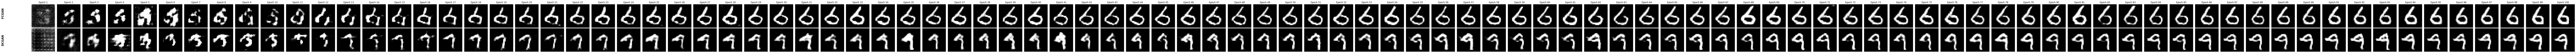

In [25]:
# Side-by-side visualization with row labels
def visualize_side_by_side(fcgan_images, dcgan_images, epochs):
    fig, axes = plt.subplots(2, epochs, figsize=(epochs * 2, 4))

    for i in range(epochs):
        # FCGAN images
        axes[0, i].imshow((fcgan_images[i][0, :, :, 0] + 1) / 2.0, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Epoch {i + 1}")

        # DCGAN images
        axes[1, i].imshow((dcgan_images[i][0, :, :, 0] + 1) / 2.0, cmap='gray')
        axes[1, i].axis('off')

    # Adding labels for rows
    fig.text(0.04, 0.75, "FCGAN", va='center', ha='center', rotation='vertical', fontsize=15, fontweight='bold')
    fig.text(0.04, 0.25, "DCGAN", va='center', ha='center', rotation='vertical', fontsize=15, fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust layout to accommodate labels
    plt.show()


if fcgan_images and dcgan_images:
    print("Visualizing side-by-side comparison...")
    visualize_side_by_side(fcgan_images, dcgan_images, min(len(fcgan_images), len(dcgan_images)))
